# **Regression on imbalanced datasets using label Label Distribution Smoothing (LDS)**

This notebook is based on the material created by the author of the paper in XXX. It usese the [Boston Housing dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html), which models the house prices in Boston using 14 variables. This dataset is nice to use because it's small and it can be trained on without using GPUs.

## Let's look at the datasets

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_folder = './data/'
# Load balanced dataset
data_train_balanced = np.loadtxt(data_folder+'housing_balanced.data.train')
data_val_balanced = np.loadtxt(data_folder+'housing_balanced.data.val')
data_test_balanced = np.loadtxt(data_folder+'housing_balanced.data.test')

# Load imbalanced dataset
data_train = np.loadtxt(data_folder+'housing.data.train')
data_val = np.loadtxt(data_folder+'housing.data.val')
data_test = np.loadtxt(data_folder+'housing.data.test')

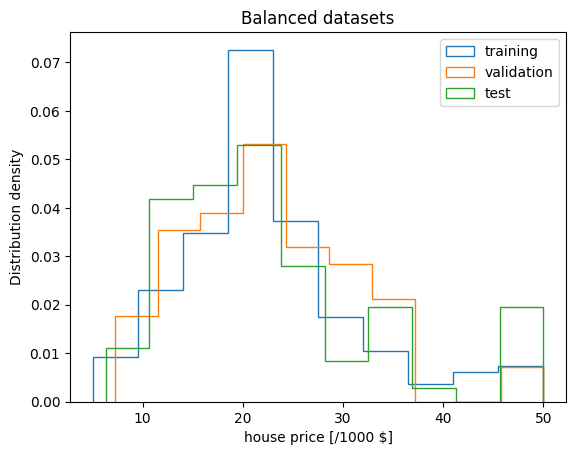

In [3]:
# Let's plot the distribution of the values to predict for the balanced dataset
plt.hist(data_train_balanced[:,-1],density=True,histtype='step',label='training')
plt.hist(data_val_balanced[:,-1],density=True,histtype='step',label='validation')
plt.hist(data_test_balanced[:,-1],density=True,histtype='step',label='test')
plt.xlabel('house price [/1000 $]')
plt.ylabel('Distribution density')
plt.title('Balanced datasets')
plt.legend()
plt.show()

They all nicely peak around 20, although the peak is not super sharp for validation and test, likely because they contain a small number of points and it's not easy to sample well sharp features

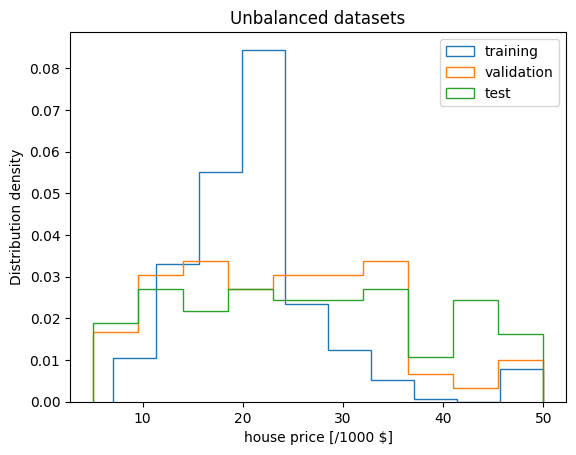

In [4]:
# Let's plot the distribution of the values to predict for the unbalanced dataset
plt.hist(data_train[:,-1],density=True,histtype='step',label='training')
plt.hist(data_val[:,-1],density=True,histtype='step',label='validation')
plt.hist(data_test[:,-1],density=True,histtype='step',label='test')
plt.xlabel('house price [/1000 $]')
plt.ylabel('Distribution density')
plt.title('Unbalanced datasets')
plt.legend()
plt.show()

Here we picked a split in which both test and validation are more flat distributions compared to the training distribution to show the effect of this in the inference

## Define the deep learning (neural network) model architecture.

In [5]:
# Let's define a simple fully connected network with 2 hidden layers
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):

    def __init__(self, layers, dropout=None):
        super(FCNet, self).__init__()
        self.fc0 = nn.Linear(13, layers[0])
        self.fc1 = nn.Linear(layers[0], layers[1])
        self.fc2 = nn.Linear(layers[1], layers[2])
        self.fc_final = nn.Linear(layers[-1], 1)

    def forward(self, x, targets=None, epoch=None):
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_final(x)

        return x

def fcnet1(**kwargs):
    return FCNet([256, 256, 256], **kwargs)


## Define the loss functions

In [6]:
import torch
import torch.nn.functional as F

def weighted_mse_loss(inputs, targets, weights=None):
    loss = (inputs - targets) ** 2
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def weighted_l1_loss(inputs, targets, weights=None):
    loss = F.l1_loss(inputs, targets, reduction='none')
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def weighted_focal_mse_loss(inputs, targets, weights=None, activate='sigmoid', beta=.2, gamma=1):
    loss = (inputs - targets) ** 2
    loss *= (torch.tanh(beta * torch.abs(inputs - targets))) ** gamma if activate == 'tanh' else \
        (2 * torch.sigmoid(beta * torch.abs(inputs - targets)) - 1) ** gamma
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def weighted_focal_l1_loss(inputs, targets, weights=None, activate='sigmoid', beta=.2, gamma=1):
    loss = F.l1_loss(inputs, targets, reduction='none')
    loss *= (torch.tanh(beta * torch.abs(inputs - targets))) ** gamma if activate == 'tanh' else \
        (2 * torch.sigmoid(beta * torch.abs(inputs - targets)) - 1) ** gamma
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def weighted_huber_loss(inputs, targets, weights=None, beta=1.):
    l1_loss = torch.abs(inputs - targets)
    cond = l1_loss < beta
    loss = torch.where(cond, 0.5 * l1_loss ** 2 / beta, l1_loss - 0.5 * beta)
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss


## Define some utility functions (not the focus of this workshop).

In [7]:
import os
import shutil
import torch
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal.windows import triang

class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    @staticmethod
    def _get_batch_fmtstr(num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

def query_yes_no(question):
    """ Ask a yes/no question via input() and return their answer. """
    valid = {"yes": True, "y": True, "ye": True, "no": False, "n": False}
    prompt = " [Y/n] "

    while True:
        print(question + prompt, end=':')
        choice = input().lower()
        if choice == '':
            return valid['y']
        elif choice in valid:
            return valid[choice]
        else:
            print("Please respond with 'yes' or 'no' (or 'y' or 'n').\n")

def prepare_folders(args):
    folders_util = [args.store_root, os.path.join(args.store_root, args.store_name)]
    if os.path.exists(folders_util[-1]) and not args.resume and not args.evaluate:
        if query_yes_no('overwrite previous folder: {} ?'.format(folders_util[-1])):
            shutil.rmtree(folders_util[-1])
            print(folders_util[-1] + ' removed.')
        else:
            raise RuntimeError('Output folder {} already exists'.format(folders_util[-1]))
    for folder in folders_util:
        if not os.path.exists(folder):
            print(f"===> Creating folder: {folder}")
            os.mkdir(folder)

def adjust_learning_rate(optimizer, epoch, args):
    lr = args.lr
    for milestone in args.schedule:
        lr *= 0.1 if epoch >= milestone else 1.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def save_checkpoint(args, state, is_best, prefix=''):
    filename = f"{args.store_root}/{args.store_name}/{prefix}ckpt.pth.tar"
    torch.save(state, filename)
    if is_best:
        print("===> Saving current best checkpoint...")
        print(f"Filename = {filename}")
        shutil.copyfile(filename, filename.replace('pth.tar', 'best.pth.tar'))


def get_lds_kernel_window(kernel, ks, sigma):
    assert kernel in ['gaussian', 'triang', 'laplace']
    half_ks = (ks - 1) // 2
    if kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    elif kernel == 'triang':
        kernel_window = triang(ks)
    else:
        laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / max(map(laplace, np.arange(-half_ks, half_ks + 1)))

    return kernel_window


## Define the data loader.

In [8]:
from scipy.ndimage import convolve1d
import os
import numpy as np
from torch.utils import data

class BostonHousing(data.Dataset):
    def __init__(self, data_dir, split='train', reweight='none',
                 lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):
        self.split = split
        self.data = np.loadtxt(data_dir, dtype='float32')
        self.weights = self._prepare_weights(reweight=reweight, lds=lds, lds_kernel=lds_kernel, lds_ks=lds_ks, lds_sigma=lds_sigma)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        index = index % self.data.shape[0]
        feature = self.data[index, :-1]
        label = np.expand_dims(np.asarray(self.data[index, -1]), axis=0)
        weight = np.asarray([self.weights[index]]).astype('float32') if self.weights is not None else np.asarray([np.float32(1.)])
        return feature, label, weight

    def _prepare_weights(self, reweight, max_target=51, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):
        assert reweight in {'none', 'inverse', 'sqrt_inv'}
        assert reweight != 'none' if lds else True, \
            "Set reweight to \'sqrt_inv\' (default) or \'inverse\' when using LDS"

        value_dict = {x: 0 for x in range(max_target)}
        labels = self.data[:, -1].tolist()
        # mbr
        for label in labels:
            value_dict[min(max_target - 1, int(label))] += 1
        if reweight == 'sqrt_inv':
            value_dict = {k: np.sqrt(v) for k, v in value_dict.items()}
        elif reweight == 'inverse':
            value_dict = {k: np.clip(v, 5, 1000) for k, v in value_dict.items()}  # clip weights for inverse re-weight
        num_per_label = [value_dict[min(max_target - 1, int(label))] for label in labels]
        if not len(num_per_label) or reweight == 'none':
            return None
        print(f"Using re-weighting: [{reweight.upper()}]")

        if lds:
            lds_kernel_window = get_lds_kernel_window(lds_kernel, lds_ks, lds_sigma)
            print(f'Using LDS: [{lds_kernel.upper()}] ({lds_ks}/{lds_sigma})')
            smoothed_value = convolve1d(
                np.asarray([v for _, v in value_dict.items()]), weights=lds_kernel_window, mode='constant')
            num_per_label = [smoothed_value[min(max_target - 1, int(label))] for label in labels]

        weights = [np.float32(1 / x) for x in num_per_label]
        scaling = len(weights) / np.sum(weights)
        weights = [scaling * x for x in weights]
        return weights


## Setup some configurations in the NN

In [9]:
import time
import argparse
#import logging
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
from scipy.stats import gmean

import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

import os
os.environ["KMP_WARNINGS"] = "FALSE"

parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
# CPU only
parser.add_argument('--cpu_only', action='store_true', default=True, help='whether to use CPU only')
# imbalanced related
# LDS
parser.add_argument('--lds', action='store_true', default=False, help='whether to enable LDS')
parser.add_argument('--lds_kernel', type=str, default='gaussian',
                    choices=['gaussian', 'triang', 'laplace'], help='LDS kernel type')
parser.add_argument('--lds_ks', type=int, default=9, help='LDS kernel size: should be odd number')
parser.add_argument('--lds_sigma', type=float, default=1, help='LDS gaussian/laplace kernel sigma')

# re-weighting: SQRT_INV / INV
parser.add_argument('--reweight', type=str, default='none', choices=['none', 'sqrt_inv', 'inverse'], help='cost-sensitive reweighting scheme')

# training/optimization related
parser.add_argument('--dataset', type=str, default='bostonhousing', choices=['imdb_wiki', 'agedb'], help='dataset name')
parser.add_argument('--data_dir', type=str, default='./data/housing_balanced.data', help='data directory')
parser.add_argument('--model', type=str, default='fcnet1', help='model name')
parser.add_argument('--store_root', type=str, default='checkpoint', help='root path for storing checkpoints, logs')
parser.add_argument('--store_name', type=str, default='', help='experiment store name')
parser.add_argument('--gpu', type=int, default=None)
parser.add_argument('--optimizer', type=str, default='adam', choices=['adam', 'sgd'], help='optimizer type')
parser.add_argument('--loss', type=str, default='l1', choices=['mse', 'l1', 'focal_l1', 'focal_mse', 'huber'], help='training loss type')
parser.add_argument('--lr', type=float, default=1e-3, help='initial learning rate')
parser.add_argument('--epoch', type=int, default=100, help='number of epochs to train')
parser.add_argument('--momentum', type=float, default=0.9, help='optimizer momentum')
parser.add_argument('--weight_decay', type=float, default=1e-4, help='optimizer weight decay')
parser.add_argument('--schedule', type=int, nargs='*', default=[60, 80], help='lr schedule (when to drop lr by 10x)')
#parser.add_argument('--batch_size', type=int, default=256, help='batch size')
parser.add_argument('--batch_size', type=int, default=64, help='batch size')
parser.add_argument('--print_freq', type=int, default=10, help='logging frequency')
parser.add_argument('--img_size', type=int, default=224, help='image size used in training')
parser.add_argument('--workers', type=int, default=0, help='number of workers used in data loading')
# checkpoints
parser.add_argument('--resume', type=str, default='', help='checkpoint file path to resume training')
parser.add_argument('--evaluate', action='store_true', help='evaluate only flag')

parser.set_defaults(augment=True)
args, unknown = parser.parse_known_args()
args.start_epoch = 0


## Define train/validation loop + test.

In [10]:
def training_validation_test_loop():
    if args.gpu is not None:
        print(f"Use GPU: {args.gpu} for training")

    # Data
    print('=====> Preparing data...')
    train_labels = np.loadtxt(args.data_dir+'.train')[:, -1]

    train_dataset = BostonHousing(data_dir=args.data_dir+'.train', split='train',
                          reweight=args.reweight, lds=args.lds, lds_kernel=args.lds_kernel, lds_ks=args.lds_ks, lds_sigma=args.lds_sigma)
    val_dataset = BostonHousing(data_dir=args.data_dir+'.val', split='val')
    test_dataset = BostonHousing(data_dir=args.data_dir+'.test', split='test')

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True,
                              num_workers=args.workers, pin_memory=True, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False,
                            num_workers=args.workers, pin_memory=True, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False,
                             num_workers=args.workers, pin_memory=True, drop_last=False)
    print(f"Training data size: {len(train_dataset)}")
    print(f"Validation data size: {len(val_dataset)}")
    print(f"Test data size: {len(test_dataset)}")

    # Random Seed
    np.random.seed(999)
    # random.seed(999)
    torch.manual_seed(999)

    # Model
    print('=====> Building model...')
    model = fcnet1()
    if not args.cpu_only:
        model = model.cuda()

    # evaluate only
    if args.evaluate:
        assert args.resume, 'Specify a trained model using [args.resume]'
        checkpoint = torch.load(args.resume)
        model.load_state_dict(checkpoint['state_dict'], strict=False)
        print(f"===> Checkpoint '{args.resume}' loaded (epoch [{checkpoint['epoch']}]), testing...")
        validate(test_loader, model, train_labels=train_labels, prefix='Test')
        return

    # Loss and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr) if args.optimizer == 'adam' else \
        torch.optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

    if args.resume:
        if os.path.isfile(args.resume):
            print(f"===> Loading checkpoint '{args.resume}'")
            checkpoint = torch.load(args.resume) if args.gpu is None else \
                torch.load(args.resume, map_location=torch.device(f'cuda:{str(args.gpu)}'))
            args.start_epoch = checkpoint['epoch']
            args.best_loss = checkpoint['best_loss']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print(f"===> Loaded checkpoint '{args.resume}' (Epoch [{checkpoint['epoch']}])")
        else:
            print(f"===> No checkpoint found at '{args.resume}'")

    if not args.cpu_only:
        cudnn.benchmark = True

    for epoch in range(args.start_epoch, args.epoch):
        adjust_learning_rate(optimizer, epoch, args)
        train_loss = train(train_loader, model, optimizer, epoch)
        val_loss_mse, val_loss_l1, val_loss_gmean = validate(val_loader, model, train_labels=train_labels)

        loss_metric = val_loss_mse if args.loss == 'mse' else val_loss_l1
        is_best = loss_metric < args.best_loss
        args.best_loss = min(loss_metric, args.best_loss)
        print(f"Best {'L1' if 'l1' in args.loss else 'MSE'} Loss: {args.best_loss:.3f}")
        save_checkpoint(args, {
            'epoch': epoch + 1,
            'model': args.model,
            'best_loss': args.best_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, is_best)
        print(f"Epoch #{epoch}: Train loss [{train_loss:.4f}]; "
              f"Val loss: MSE [{val_loss_mse:.4f}], L1 [{val_loss_l1:.4f}], G-Mean [{val_loss_gmean:.4f}]")

    # test with best checkpoint
    print("=" * 120)
    print("Test best model on testset...")
    checkpoint = torch.load(f"{args.store_root}/{args.store_name}/ckpt.best.pth.tar")
    model.load_state_dict(checkpoint['state_dict'])
    print(f"Loaded best model, epoch {checkpoint['epoch']}, best val loss {checkpoint['best_loss']:.4f}")
    test_loss_mse, test_loss_l1, test_loss_gmean = validate(test_loader, model, train_labels=train_labels, prefix='Test')
    print(f"Test loss: MSE [{test_loss_mse:.4f}], L1 [{test_loss_l1:.4f}], G-Mean [{test_loss_gmean:.4f}]\nDone")

def train(train_loader, model, optimizer, epoch):
    batch_time = AverageMeter('Time', ':6.2f')
    data_time = AverageMeter('Data', ':6.4f')
    losses = AverageMeter(f'Loss ({args.loss.upper()})', ':.3f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses],
        prefix="Epoch: [{}]".format(epoch)
    )

    model.train()
    end = time.time()
    for idx, (inputs, targets, weights) in enumerate(train_loader):
        data_time.update(time.time() - end)
        if not args.cpu_only:
            inputs, targets, weights = \
                inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True), weights.cuda(non_blocking=True)
        outputs = model(inputs, targets, epoch)

        loss = globals()[f"weighted_{args.loss}_loss"](outputs, targets, weights)
        assert not (np.isnan(loss.item()) or loss.item() > 1e6), f"Loss explosion: {loss.item()}"

        losses.update(loss.item(), inputs.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()
        if idx % args.print_freq == 0:
            progress.display(idx)

    return losses.avg

def validate(val_loader, model, train_labels=None, prefix='Val'):
    batch_time = AverageMeter('Time', ':6.3f')
    losses_mse = AverageMeter('Loss (MSE)', ':.3f')
    losses_l1 = AverageMeter('Loss (L1)', ':.3f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses_mse, losses_l1],
        prefix=f'{prefix}: '
    )

    criterion_mse = nn.MSELoss()
    criterion_l1 = nn.L1Loss()
    criterion_gmean = nn.L1Loss(reduction='none')

    model.eval()
    losses_all = []
    preds, labels = [], []
    with torch.no_grad():
        end = time.time()
        for idx, (inputs, targets, _) in enumerate(val_loader):
            if not args.cpu_only:
                inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True)
            outputs = model(inputs)

            preds.extend(outputs.data.cpu().numpy())
            labels.extend(targets.data.cpu().numpy())

            loss_mse = criterion_mse(outputs, targets)
            loss_l1 = criterion_l1(outputs, targets)
            loss_all = criterion_gmean(outputs, targets)
            losses_all.extend(loss_all.cpu().numpy())

            losses_mse.update(loss_mse.item(), inputs.size(0))
            losses_l1.update(loss_l1.item(), inputs.size(0))

            batch_time.update(time.time() - end)
            end = time.time()
            if idx % args.print_freq == 0:
                progress.display(idx)

        shot_dict = shot_metrics(np.hstack(preds), np.hstack(labels), train_labels)
        loss_gmean = gmean(np.hstack(losses_all), axis=None).astype(float)
        print(f" * Overall: MSE {losses_mse.avg:.3f}\tL1 {losses_l1.avg:.3f}\tG-Mean {loss_gmean:.3f}")
        print(f" * Many: MSE {shot_dict['many']['mse']:.3f}\t"
              f"L1 {shot_dict['many']['l1']:.3f}\tG-Mean {shot_dict['many']['gmean']:.3f}")
        print(f" * Median: MSE {shot_dict['median']['mse']:.3f}\t"
              f"L1 {shot_dict['median']['l1']:.3f}\tG-Mean {shot_dict['median']['gmean']:.3f}")
        print(f" * Low: MSE {shot_dict['low']['mse']:.3f}\t"
              f"L1 {shot_dict['low']['l1']:.3f}\tG-Mean {shot_dict['low']['gmean']:.3f}")

    return losses_mse.avg, losses_l1.avg, loss_gmean

def shot_metrics(preds, labels, train_labels, many_shot_thr=10, low_shot_thr=2):
    train_labels = np.array(train_labels).astype(int)

    if isinstance(preds, torch.Tensor):
        preds = preds.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
    elif isinstance(preds, np.ndarray):
        pass
    else:
        raise TypeError(f'Type ({type(preds)}) of predictions not supported')

    labels = np.array(labels).astype(int)

    train_class_count, test_class_count = [], []
    mse_per_class, l1_per_class, l1_all_per_class = [], [], []
    for l in np.unique(labels):
        train_class_count.append(len(train_labels[train_labels == l]))
        test_class_count.append(len(labels[labels == l]))
        mse_per_class.append(np.sum((preds[labels == l] - labels[labels == l]) ** 2))
        l1_per_class.append(np.sum(np.abs(preds[labels == l] - labels[labels == l])))
        l1_all_per_class.append(np.abs(preds[labels == l] - labels[labels == l]))

    many_shot_mse, median_shot_mse, low_shot_mse = [], [], []
    many_shot_l1, median_shot_l1, low_shot_l1 = [], [], []
    many_shot_gmean, median_shot_gmean, low_shot_gmean = [], [], []
    many_shot_cnt, median_shot_cnt, low_shot_cnt = [], [], []

    for i in range(len(train_class_count)):
        if train_class_count[i] > many_shot_thr:
            many_shot_mse.append(mse_per_class[i])
            many_shot_l1.append(l1_per_class[i])
            many_shot_gmean += list(l1_all_per_class[i])
            many_shot_cnt.append(test_class_count[i])
        elif train_class_count[i] < low_shot_thr:
            low_shot_mse.append(mse_per_class[i])
            low_shot_l1.append(l1_per_class[i])
            low_shot_gmean += list(l1_all_per_class[i])
            low_shot_cnt.append(test_class_count[i])
        else:
            median_shot_mse.append(mse_per_class[i])
            median_shot_l1.append(l1_per_class[i])
            median_shot_gmean += list(l1_all_per_class[i])
            median_shot_cnt.append(test_class_count[i])

    shot_dict = defaultdict(dict)
    shot_dict['many']['mse'] = np.sum(many_shot_mse) / np.sum(many_shot_cnt)
    shot_dict['many']['l1'] = np.sum(many_shot_l1) / np.sum(many_shot_cnt)
    shot_dict['many']['gmean'] = gmean(np.hstack(many_shot_gmean), axis=None).astype(float)
    shot_dict['median']['mse'] = np.sum(median_shot_mse) / np.sum(median_shot_cnt)
    shot_dict['median']['l1'] = np.sum(median_shot_l1) / np.sum(median_shot_cnt)
    shot_dict['median']['gmean'] = gmean(np.hstack(median_shot_gmean), axis=None).astype(float)
    shot_dict['low']['mse'] = np.sum(low_shot_mse) / np.sum(low_shot_cnt)
    shot_dict['low']['l1'] = np.sum(low_shot_l1) / np.sum(low_shot_cnt)
    shot_dict['low']['gmean'] = gmean(np.hstack(low_shot_gmean), axis=None).astype(float)

    return shot_dict

## Let's train the model on the balanced dataset without using the LDS

In [11]:
# Let's start with the balanced data training
args.data_dir = './data/housing_balanced.data'
args.reweight = 'none'
args.lds = False
args.store_name = 'baseline'

if len(args.store_name):
    args.store_name = f'_{args.store_name}'
if not args.lds and args.reweight != 'none':
    args.store_name += f'_{args.reweight}'
if args.lds:
    args.store_name += f'_lds_{args.lds_kernel[:3]}_{args.lds_ks}'
    if args.lds_kernel in ['gaussian', 'laplace']:
        args.store_name += f'_{args.lds_sigma}'
args.store_name = f"{args.dataset}_{args.model}{args.store_name}_{args.optimizer}_{args.loss}_{args.lr}_{args.batch_size}"
args.best_loss = 1e5

prepare_folders(args)

print(f"Args: {args}")
print(f"Store name: {args.store_name}")

training_validation_test_loop()

===> Creating folder: checkpoint/bostonhousing_fcnet1_baseline_adam_l1_0.001_64
Args: Namespace(cpu_only=True, lds=False, lds_kernel='gaussian', lds_ks=9, lds_sigma=1, reweight='none', dataset='bostonhousing', data_dir='./data/housing_balanced.data', model='fcnet1', store_root='checkpoint', store_name='bostonhousing_fcnet1_baseline_adam_l1_0.001_64', gpu=None, optimizer='adam', loss='l1', lr=0.001, epoch=100, momentum=0.9, weight_decay=0.0001, schedule=[60, 80], batch_size=64, print_freq=10, img_size=224, workers=0, resume='', evaluate=False, augment=True, start_epoch=0, best_loss=100000.0)
Store name: bostonhousing_fcnet1_baseline_adam_l1_0.001_64
=====> Preparing data...
Training data size: 358
Validation data size: 66
Test data size: 82
=====> Building model...
Epoch: [0][0/6]	Time   0.00 (  0.00)	Data 0.0008 (0.0008)	Loss (L1) 19.640 (19.640)
Val: [0/2]	Time  0.001 ( 0.001)	Loss (MSE) 93.498 (93.498)	Loss (L1) 7.583 (7.583)
 * Overall: MSE 107.099	L1 7.917	G-Mean 5.188
 * Many: MSE

## Let's now infer on the balanced test sets

In [12]:
# Small function to perform inference
def infer(val_loader, model):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for _, (inputs, targets, _) in enumerate(val_loader):
            if not args.cpu_only:
                inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True)
            outputs = model(inputs)
            preds.extend(outputs.data.cpu().numpy())
            labels.extend(targets.data.cpu().numpy())
    return np.array(preds), np.array(labels)

In [13]:
# Define the model
model = fcnet1()
if not args.cpu_only:
    model = model.cuda()

In [14]:
# Load the weights
print(args.store_name)
checkpoint = torch.load(f"{args.store_root}/{args.store_name}/ckpt.best.pth.tar")
model.load_state_dict(checkpoint['state_dict'])

bostonhousing_fcnet1_baseline_adam_l1_0.001_64


<All keys matched successfully>

In [15]:
# Let's load the balanced datasets and predict on them. Disclaimer, here we actually trained on
test_balanced_dataset = BostonHousing(data_dir='./data/housing_balanced.data.test', split='test')
test_loader_balanced_dataset = DataLoader(test_balanced_dataset, batch_size=args.batch_size)

In [16]:
prediction_balanced_dataset, labels_balanced_dataset = infer(test_loader_balanced_dataset,model)

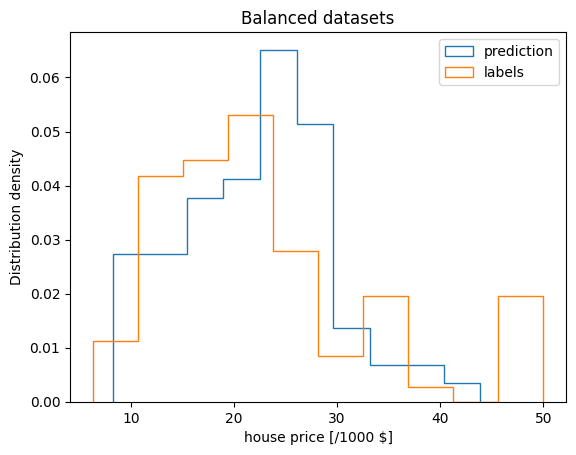

In [17]:
plt.hist(prediction_balanced_dataset,histtype='step',label='prediction',density=True)
plt.hist(labels_balanced_dataset,histtype='step',label='labels',density=True)
plt.legend()
plt.xlabel('house price [/1000 $]')
plt.ylabel('Distribution density')
plt.title('Balanced datasets')
plt.legend()
plt.show()
plt.show()

/Users/rcotesta/Projects/deep_imbalanced_regression/imbalanced_regression_workshop/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:10744: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/rcotesta/Projects/deep_imbalanced_regression/imbalanced_regression_workshop/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:10750: RuntimeWarning: invalid value encountered in sqrt
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


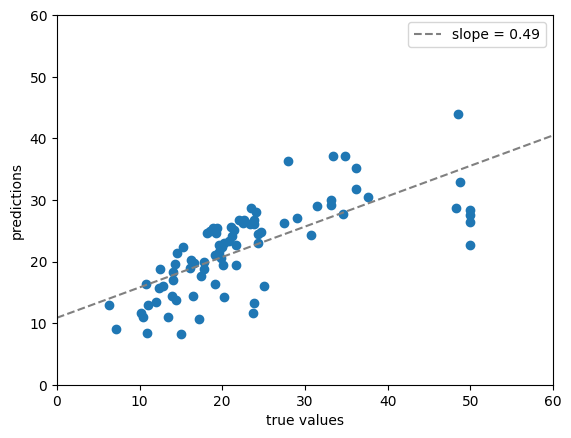

In [28]:
from scipy.stats import linregress
fit_balanced = linregress(labels_balanced_dataset.reshape(1,-1),prediction_balanced_dataset.reshape(1,-1))
plt.scatter(labels_balanced_dataset,prediction_balanced_dataset)
x_values = np.linspace(0,60,num=1000)
predictions_fit = fit_balanced.slope * x_values + fit_balanced.intercept
plt.plot(x_values,predictions_fit,label=f'slope = {fit_balanced.slope:.2f}',ls='--',c='grey')
plt.xlabel('true values')
plt.ylabel('predictions')
plt.legend()
plt.xlim(0,60)
plt.ylim(0,60)
plt.show()

We get a decent result

## Let's now train the model on the unbalanced dataset without using the LDS

In [29]:
# Let's start with the balanced data training
args.data_dir = './data/housing.data'
args.reweight = 'none'
args.lds = False
args.store_name = 'baseline_unbalanced'

if len(args.store_name):
    args.store_name = f'_{args.store_name}'
if not args.lds and args.reweight != 'none':
    args.store_name += f'_{args.reweight}'
if args.lds:
    args.store_name += f'_lds_{args.lds_kernel[:3]}_{args.lds_ks}'
    if args.lds_kernel in ['gaussian', 'laplace']:
        args.store_name += f'_{args.lds_sigma}'
args.store_name = f"{args.dataset}_{args.model}{args.store_name}_{args.optimizer}_{args.loss}_{args.lr}_{args.batch_size}"
args.best_loss = 1e5

prepare_folders(args)

print(f"Args: {args}")
print(f"Store name: {args.store_name}")

training_validation_test_loop()

===> Creating folder: checkpoint/bostonhousing_fcnet1_baseline_unbalanced_adam_l1_0.001_64
Args: Namespace(cpu_only=True, lds=False, lds_kernel='gaussian', lds_ks=9, lds_sigma=1, reweight='none', dataset='bostonhousing', data_dir='./data/housing.data', model='fcnet1', store_root='checkpoint', store_name='bostonhousing_fcnet1_baseline_unbalanced_adam_l1_0.001_64', gpu=None, optimizer='adam', loss='l1', lr=0.001, epoch=100, momentum=0.9, weight_decay=0.0001, schedule=[60, 80], batch_size=64, print_freq=10, img_size=224, workers=0, resume='', evaluate=False, augment=True, start_epoch=0, best_loss=100000.0)
Store name: bostonhousing_fcnet1_baseline_unbalanced_adam_l1_0.001_64
=====> Preparing data...
Training data size: 358
Validation data size: 66
Test data size: 82
=====> Building model...
Epoch: [0][0/6]	Time   0.00 (  0.00)	Data 0.0008 (0.0008)	Loss (L1) 19.400 (19.400)
Val: [0/2]	Time  0.003 ( 0.003)	Loss (MSE) 76.274 (76.274)	Loss (L1) 7.200 (7.200)
 * Overall: MSE 98.724	L1 7.848	G-

## Let's now infer on the imbalanced test sets

In [33]:
# Load the weights
print(args.store_name)
checkpoint = torch.load(f"{args.store_root}/{args.store_name}/ckpt.best.pth.tar")
model.load_state_dict(checkpoint['state_dict'])

bostonhousing_fcnet1_baseline_unbalanced_adam_l1_0.001_64


<All keys matched successfully>

In [36]:
# Let's load the unbalanced datasets and predict on them
test_unbalanced_dataset = BostonHousing(data_dir='./data/housing.data.test', split='test')
test_loader_imbalanced_dataset = DataLoader(test_unbalanced_dataset, batch_size=args.batch_size)
prediction_imbalanced_dataset, labels_imbalanced_dataset = infer(test_loader_imbalanced_dataset,model)

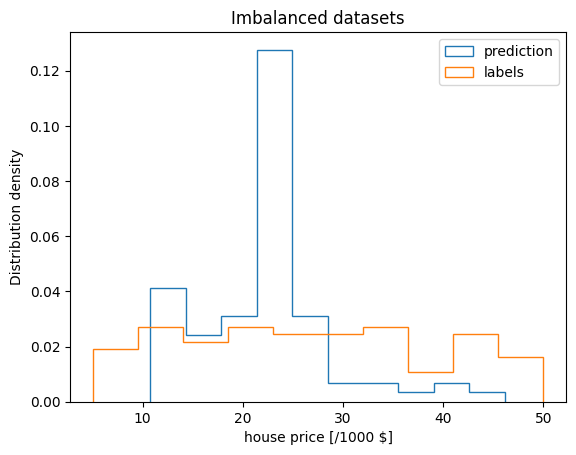

In [37]:
plt.hist(prediction_imbalanced_dataset,histtype='step',label='prediction',density=True)
plt.hist(labels_imbalanced_dataset,histtype='step',label='labels',density=True)
plt.legend()
plt.xlabel('house price [/1000 $]')
plt.ylabel('Distribution density')
plt.title('Imbalanced datasets')
plt.legend()
plt.show()
plt.show()

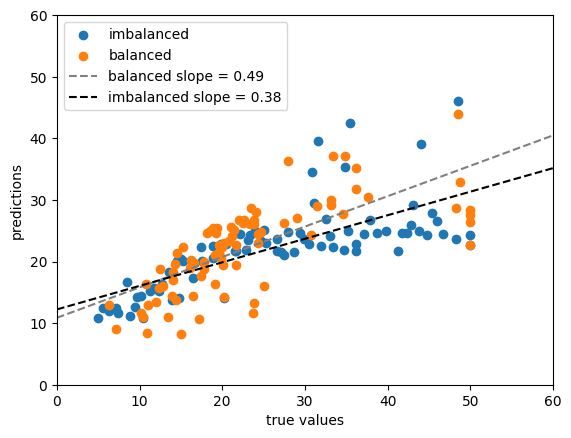

In [40]:
plt.scatter(labels_imbalanced_dataset,prediction_imbalanced_dataset,label='imbalanced')
plt.scatter(labels_balanced_dataset,prediction_balanced_dataset,label='balanced')
fit_imbalanced = linregress(labels_imbalanced_dataset.reshape(1,-1),prediction_imbalanced_dataset.reshape(1,-1))
predictions_fit_imbalanced = fit_imbalanced.slope * x_values + fit_imbalanced.intercept
plt.plot(x_values,predictions_fit,label=f'balanced slope = {fit_balanced.slope:.2f}',ls='--',c='grey')
plt.plot(x_values,predictions_fit_imbalanced,label=f'imbalanced slope = {fit_imbalanced.slope:.2f}',ls='--',c='k')
plt.xlabel('true values')
plt.ylabel('predictions')
plt.xlim(0,60)
plt.ylim(0,60)
plt.legend()
plt.show()

The training on imbalanced dataset gives worst predictions, because it keeps predicting values from the mode of the training distribution

## Let's finally train the model on the imbalanced dataset using the LDS

In [41]:
args.data_dir = './data/housing.data'
args.reweight = 'sqrt_inv'
args.lds = True
args.lds_kernel = 'gaussian'
args.lds_ks = 5 # 5
args.lds_sigma = 2 # 2
args.store_name = 'lds_imbalanced'

if len(args.store_name):
    args.store_name = f'_{args.store_name}'
if not args.lds and args.reweight != 'none':
    args.store_name += f'_{args.reweight}'
if args.lds:
    args.store_name += f'_lds_{args.lds_kernel[:3]}_{args.lds_ks}'
    if args.lds_kernel in ['gaussian', 'laplace']:
        args.store_name += f'_{args.lds_sigma}'
args.store_name = f"{args.dataset}_{args.model}{args.store_name}_{args.optimizer}_{args.loss}_{args.lr}_{args.batch_size}"
args.best_loss = 1e5

prepare_folders(args)

print(f"Args: {args}")
print(f"Store name: {args.store_name}")

training_validation_test_loop()

===> Creating folder: checkpoint/bostonhousing_fcnet1_lds_imbalanced_lds_gau_5_2_adam_l1_0.001_64
Args: Namespace(cpu_only=True, lds=True, lds_kernel='gaussian', lds_ks=5, lds_sigma=2, reweight='sqrt_inv', dataset='bostonhousing', data_dir='./data/housing.data', model='fcnet1', store_root='checkpoint', store_name='bostonhousing_fcnet1_lds_imbalanced_lds_gau_5_2_adam_l1_0.001_64', gpu=None, optimizer='adam', loss='l1', lr=0.001, epoch=100, momentum=0.9, weight_decay=0.0001, schedule=[60, 80], batch_size=64, print_freq=10, img_size=224, workers=0, resume='', evaluate=False, augment=True, start_epoch=0, best_loss=100000.0)
Store name: bostonhousing_fcnet1_lds_imbalanced_lds_gau_5_2_adam_l1_0.001_64
=====> Preparing data...
Using re-weighting: [SQRT_INV]
Using LDS: [GAUSSIAN] (5/2)
Training data size: 358
Validation data size: 66
Test data size: 82
=====> Building model...
Epoch: [0][0/6]	Time   0.00 (  0.00)	Data 0.0007 (0.0007)	Loss (L1) 20.863 (20.863)
Val: [0/2]	Time  0.001 ( 0.001)	Lo

## Let's now infer on the unbalanced test sets using LDS

In [42]:
# Load the weights
print(args.store_name)
checkpoint = torch.load(f"{args.store_root}/{args.store_name}/ckpt.best.pth.tar")
model.load_state_dict(checkpoint['state_dict'])

bostonhousing_fcnet1_lds_imbalanced_lds_gau_5_2_adam_l1_0.001_64


<All keys matched successfully>

In [43]:
# Let's predict on the unbalanced datasets using LDS
prediction_imbalanced_dataset_lds, labels_imbalanced_dataset_lds = infer(test_loader_imbalanced_dataset,model)

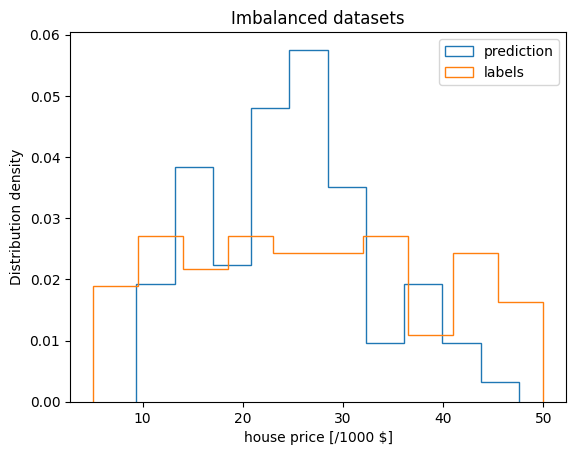

In [45]:
plt.hist(prediction_imbalanced_dataset_lds,histtype='step',label='prediction',density=True)
plt.hist(labels_imbalanced_dataset_lds,histtype='step',label='labels',density=True)
plt.legend()
plt.xlabel('house price [/1000 $]')
plt.ylabel('Distribution density')
plt.title('Imbalanced datasets')
plt.legend()
plt.show()
plt.show()

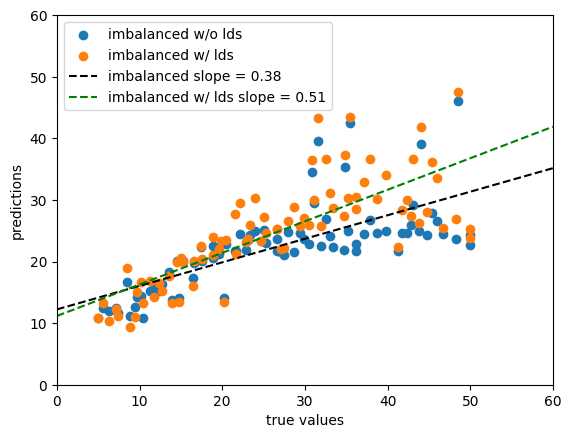

In [47]:
plt.scatter(labels_imbalanced_dataset,prediction_imbalanced_dataset,label='imbalanced w/o lds')
plt.scatter(labels_imbalanced_dataset_lds,prediction_imbalanced_dataset_lds,label='imbalanced w/ lds')
fit_imbalanced_lds = linregress(labels_imbalanced_dataset_lds.reshape(1,-1),prediction_imbalanced_dataset_lds.reshape(1,-1))
predictions_fit_imbalanced_lds = fit_imbalanced_lds.slope * x_values + fit_imbalanced_lds.intercept
plt.plot(x_values,predictions_fit_imbalanced,label=f'imbalanced slope = {fit_imbalanced.slope:.2f}',ls='--',c='k')
plt.plot(x_values,predictions_fit_imbalanced_lds,label=f'imbalanced w/ lds slope = {fit_imbalanced_lds.slope:.2f}',ls='--',c='green')
plt.xlabel('true values')
plt.ylabel('predictions')
plt.xlim(0,60)
plt.ylim(0,60)
plt.legend()
plt.show()

It works better!